In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import numpy as np
from pathlib import Path
import h5py
import faiss
import os

config = dict(
    batch_size=64,
    model_name='U-Net Simple',
    epochs=100,
    init_learning_rate=0.0001,
    lr_decay_rate=0.1,
    optimizer='adam',
    loss_fn='mean_squared_error',
    earlystopping_patience=10,
)

# Assuming your model is saved in this path
model_path = '/home/nicosepulveda/astro/bridge/model/local_1st_best_model/model-best.h5'

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Define a bottleneck model to extract features from the bottleneck layer and apply global average pooling
bottleneck_output = model.get_layer('pre_bottleneck').output
global_avg_pooling = GlobalAveragePooling2D()(bottleneck_output)
bottleneck_model = Model(inputs=model.input, outputs=global_avg_pooling)

# Normalization functions (from your code)
@tf.function
def normalize_images(images):
    img1, img2, diff_img = tf.unstack(images, axis=0)  # Unstack into three separate images
    combined = tf.stack([img1, img2], axis=0)  # Stack img1 and img2 for min/max calculation
    min_val = tf.reduce_min(combined)
    max_val = tf.reduce_max(combined)
    img1_rescaled = (img1 - min_val) / (max_val - min_val)
    img2_rescaled = (img2 - min_val) / (max_val - min_val)
    return img1_rescaled, img2_rescaled, diff_img

@tf.function
def normalize_difference_based_on_range(img1, img2, diff_img):
    difference = img1 - img2
    min_diff = tf.reduce_min(difference, keepdims=True)
    max_diff = tf.reduce_max(difference, keepdims=True)
    diff_img_rescaled = 2 * (diff_img - min_diff) / (max_diff - min_diff) - 1
    return diff_img_rescaled

@tf.function
def preprocess_image(images):
    img1, img2, diff_img = normalize_images(images)
    diff_img_rescaled = normalize_difference_based_on_range(images[0], images[1], images[2])
    input_img = tf.stack([img1, img2], axis=-1)  # Stack along the channel dimension
    input_img = tf.image.crop_to_bounding_box(input_img, 7, 7, 48, 48)  # crop

    diff_img_rescaled = tf.expand_dims(diff_img_rescaled, axis=-1)  # Ensure correct shape for output
    diff_img_rescaled = tf.image.crop_to_bounding_box(diff_img_rescaled, 7, 7, 48, 48)  # crop

    return input_img, diff_img_rescaled

def _parse_function(proto):
    keys_to_features = {
        'images': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    images = tf.io.parse_tensor(parsed_features['images'], out_type=tf.float32)
    images = tf.reshape(images, [3, 63, 63])  # Three images each 63x63
    images = tf.where(tf.math.is_nan(images), tf.zeros_like(images), images)
    return images

def load_dataset(tfrecord_paths, batch_size):
    dataset = tf.data.TFRecordDataset(tfrecord_paths)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Setup dataset
tfrecord_folder_path = "/home/nicosepulveda/astro/bridge/TFRecords"
all_tfrecord_paths = [str(path) for path in Path(tfrecord_folder_path).glob('*.tfrecord')]
val_dataset = load_dataset(all_tfrecord_paths, batch_size=config['batch_size'])

print(all_tfrecord_paths)


2025-01-10 12:48:41.997256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-10 12:48:42.538053: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2025-01-10 12:48:42.538129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2025-01-10 12:48:42.538134: W tensorflow/compiler/tf2tensorrt/utils/py_uti

['/home/nicosepulveda/astro/bridge/TFRecords/data_batch_224_259.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_224_175.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_221_114.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_381_150.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_380_222.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_221_140.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_224_96.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_224_219.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_381_1.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_224_38.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_220_154.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_221_245.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecords/data_batch_224_71.tfrecord', '/home/nicosepulveda/astro/bridge/TFRecord

In [2]:
# !pip install alerce

In [3]:
# !pip install faiss-cpu

2025-01-10 12:49:14.507908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


1/1 [==============================] - 1s 1s/step
(1, 48, 48, 1)


/tmp/ipykernel_10898/3914472312.py:50: RuntimeWarning: divide by zero encountered in log10
  images = [np.log10(input_img[0,:,:,0]), np.log10(input_img[0,:,:,1]), diff_img_rescaled[:,:,0], prediction[0,:,:,0]]


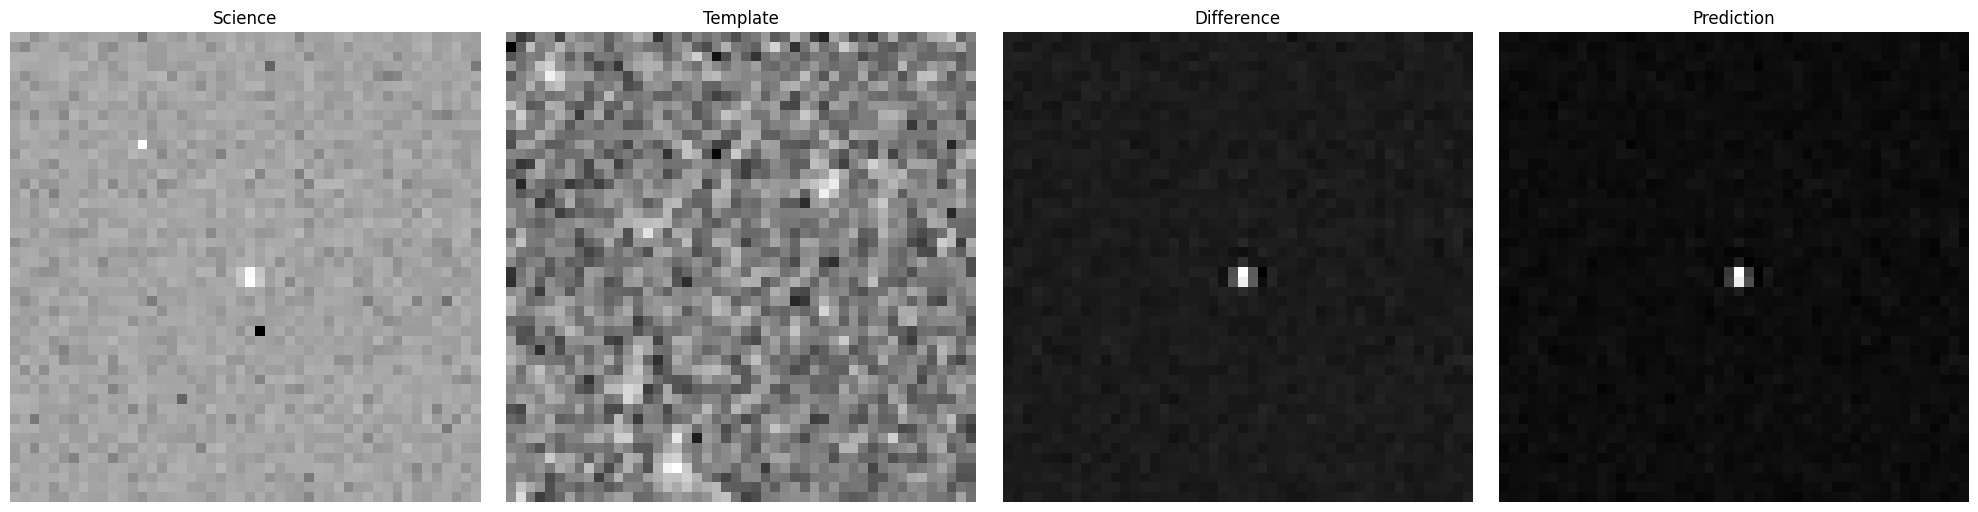

In [2]:
from alerce.core import Alerce
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import logging

# Import ALeRCE Client
client = Alerce()

# Function to fetch one triplet
def get_one_triplet(oid):
    object_det = client.query_detections(oid, format='pandas')  # Get object detections
    candids = object_det.loc[object_det.has_stamp].candid  # Obtain the candidate ids
    if not candids.empty:
        candid = candids.iloc[0]  # Get the first candid
        try:
            # Get stamps in HDUList format
            candid_stamps = client.get_stamps(oid, candid=candid, format='HDUList')
            return candid_stamps
        except Exception as e:
            logging.error(f"Error processing candid {candid}: {e}")
    return None

# Fetch a triplet
object_id =  "ZTF22abjvfii"#"ZTF24aavaawt"# "ZTF24aaocmqx"# #"ZTF24aaugbew" "ZTF24aauoxjm" #"ZTF19acrcnlp" #"ZTF24aaocmqx" #"ZTF24aavcyqa" #"ZTF24aaupmlg"# 
triplet = get_one_triplet(object_id)

if triplet is not None:
    # Process the triplet
    triplet_data = np.stack([hdu.data for hdu in triplet], axis=0)
    
    # Check the size of each image in the triplet
    sizes = [hdu.data.shape for hdu in triplet]
    logging.info(f"Triplet sizes: {sizes}")
    
    input_img, diff_img_rescaled = preprocess_image(triplet_data)
    
    
    # Extract bottleneck features
    input_img = np.expand_dims(input_img, axis=0)  # Add batch dimension
    
    # Get the model prediction
    prediction = model.predict(input_img)
    
    print(prediction.shape)

    # Plot the triplet and the prediction
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    titles = ['Science', 'Template', 'Difference', 'Prediction']
    images = [np.log10(input_img[0,:,:,0]), np.log10(input_img[0,:,:,1]), diff_img_rescaled[:,:,0], prediction[0,:,:,0]]
    
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Failed to fetch a valid triplet.")


In [6]:
!pip install annoy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from annoy import AnnoyIndex
import numpy as np
import h5py
import os

# Dimension of the latent space
d = 512
# Number of trees for the Annoy index
n_trees = 50

# Path to the HDF5 file
hdf5_file = 'Latent_Space/val_bottleneck_features.h5'

# Open the HDF5 file and read in chunks
with h5py.File(hdf5_file, 'r') as f:
    num_elements = f['features'].shape[0]
    print(f"Total number of features: {num_elements}")
    batch_size = int(512000/2)  # Adjust this batch size based on memory constraints - original: 1024000/2
    print(f"Batch size: {batch_size}")

    index_id = 0
    for start in range(0, num_elements, batch_size):
        end = min(start + batch_size, num_elements)
        batch_features = f['features'][start:end]
        
        # Normalize the batch features
        batch_features = np.log10(batch_features + 1e-3)
        
        # Create a new Annoy index for the current batch
        index = AnnoyIndex(d, 'angular')  # 'angular' is equivalent to cosine similarity
        
        # Add vectors to the Annoy index using local IDs
        for i in range(batch_features.shape[0]):
            index.add_item(i, batch_features[i])
        
        # Build the Annoy index
        print(f"Building Annoy index for batch {index_id}...")
        index.build(n_trees)
        print(f"Annoy index for batch {index_id} built.")
        
        # Save the Annoy index
        index_file = f'Latent_Space/annoy_index_{index_id}.ann'
        index.save(index_file)
        print(f"Annoy index saved to {index_file}.")
        
        index_id += 1

print("All Annoy indices created and saved.")


Total number of features: 2056192
Batch size: 256000
Building Annoy index for batch 0...
Annoy index for batch 0 built.
Annoy index saved to Latent_Space/annoy_index_0.ann.
Building Annoy index for batch 1...
Annoy index for batch 1 built.
Annoy index saved to Latent_Space/annoy_index_1.ann.
Building Annoy index for batch 2...
Annoy index for batch 2 built.
Annoy index saved to Latent_Space/annoy_index_2.ann.
Building Annoy index for batch 3...
Annoy index for batch 3 built.
Annoy index saved to Latent_Space/annoy_index_3.ann.
Building Annoy index for batch 4...
Annoy index for batch 4 built.
Annoy index saved to Latent_Space/annoy_index_4.ann.
Building Annoy index for batch 5...
Annoy index for batch 5 built.
Annoy index saved to Latent_Space/annoy_index_5.ann.
Building Annoy index for batch 6...
Annoy index for batch 6 built.
Annoy index saved to Latent_Space/annoy_index_6.ann.
Building Annoy index for batch 7...
Annoy index for batch 7 built.
Annoy index saved to Latent_Space/annoy_

In [4]:
from annoy import AnnoyIndex
import numpy as np
import h5py
import os
from multiprocessing import Pool, cpu_count

# Dimension of the latent space
d = 512

# Function to query an individual Annoy index
def query_annoy_index(args):
    index_file, query_vector, k = args
    index = AnnoyIndex(d, 'angular')
    index.load(index_file)
    indices, distances = index.get_nns_by_vector(query_vector, k, include_distances=True)
    return indices, distances, index_file

# Function to find closest images by querying multiple Annoy indices
def find_closest_images_annoy(new_image_latent, index_folder, batch_size, k=10):
    # Query all indices and combine results
    all_results = []

    index_files = sorted([os.path.join(index_folder, file) for file in os.listdir(index_folder) if file.startswith('annoy_index_') and file.endswith('.ann')])

    # Create a pool of worker processes
    pool = Pool(processes=cpu_count())

    # Prepare arguments for the pool
    args = [(index_file, new_image_latent, k) for index_file in index_files]

    # Query indices in parallel
    results = pool.map(query_annoy_index, args)

    # Close the pool
    pool.close()
    pool.join()

    for result in results:
        indices, distances, index_file = result
        index_id = index_files.index(index_file)
        for i, dist in zip(indices, distances):
            global_index = index_id * batch_size + i
            all_results.append((dist, global_index))

    # Sort the results to get the top k nearest neighbors
    all_results.sort()
    top_k_results = all_results[:k]

    final_distances = [result[0] for result in top_k_results]
    final_indices = [result[1] for result in top_k_results]

    return final_indices, final_distances

# Assuming the previous triplet and bottleneck feature extraction is successful
new_image_latent = bottleneck_model.predict(input_img)
new_image_latent = np.log10(new_image_latent + 1e-3).flatten()

# Path to the folder containing the Annoy indices
index_folder = 'Latent_Space'

# Find the closest images
closest_indices, distances = find_closest_images_annoy(new_image_latent, index_folder, batch_size=int(1024000 / 2), k=10)

print("Indices of closest images:", closest_indices)
print("Distances to closest images:", distances)

# Path to the HDF5 file
hdf5_file = 'Latent_Space/val_bottleneck_features.h5'

# Retrieve objectIds and candids
def retrieve_metadata(hdf5_file, indices):
    object_ids = []
    candids = []
    with h5py.File(hdf5_file, 'r') as f:
        max_index = len(f['object_ids'])
        for idx in indices:
            if idx >= max_index:
                print(f"Índice fuera de rango: {idx}, máximo permitido: {max_index-1}")
                continue            
            object_ids.append(f['object_ids'][idx].decode('utf-8'))
            candids.append(f['candids'][idx])
    return object_ids, candids

# Get the metadata for the closest images
object_ids, candids = retrieve_metadata(hdf5_file, closest_indices)

print("Object IDs of closest images:", object_ids)
print("Candids of closest images:", candids)



1/1 [==============================] - 0s 78ms/step
Indices of closest images: [693880, 2240639, 3186931, 1091554, 2567652, 3592260, 179574, 571738, 1265428, 2096703]
Distances to closest images: [0.037710316479206085, 0.03823700174689293, 0.03965938836336136, 0.04030507802963257, 0.04100365564227104, 0.041146907955408096, 0.04169827327132225, 0.04288063198328018, 0.04290294647216797, 0.0429714173078537]
Índice fuera de rango: 2240639, máximo permitido: 2056191
Índice fuera de rango: 3186931, máximo permitido: 2056191
Índice fuera de rango: 2567652, máximo permitido: 2056191
Índice fuera de rango: 3592260, máximo permitido: 2056191
Índice fuera de rango: 2096703, máximo permitido: 2056191
Object IDs of closest images: ['ZTF18ablooag', 'ZTF18acguvec', 'ZTF19aazszfj', 'ZTF23abownjv', 'ZTF18abgrany']
Candids of closest images: [1919487880615015232, 2133386680415010125, 896186504415015008, 2499198502215015007, 1919485001815010050]


Índice fuera de rango: 2240639, máximo permitido: 2056191
Índice fuera de rango: 3186931, máximo permitido: 2056191
Índice fuera de rango: 2567652, máximo permitido: 2056191
Índice fuera de rango: 3592260, máximo permitido: 2056191
Índice fuera de rango: 2096703, máximo permitido: 2056191


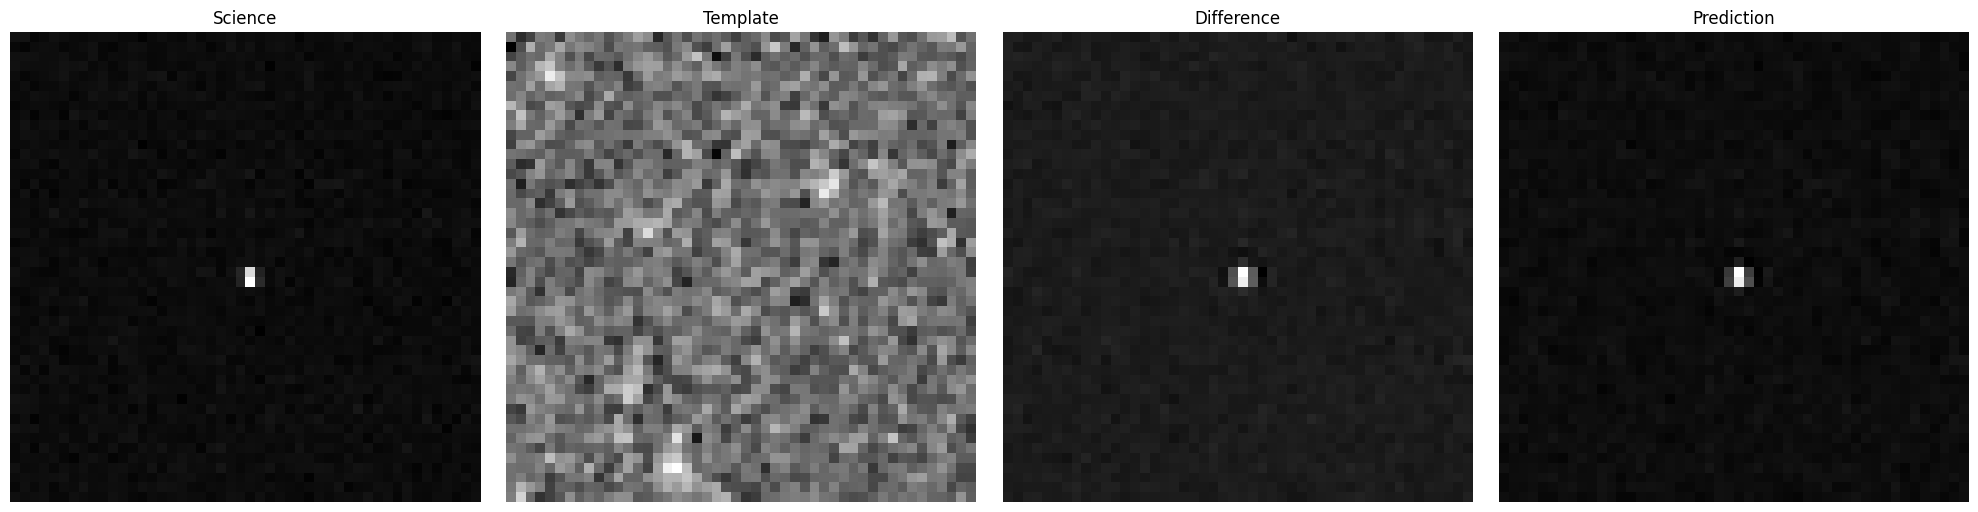

Processing Object ID: ZTF18ablooag, Candid: 1919487880615015232
1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_10898/1849374999.py:34: RuntimeWarning: divide by zero encountered in log10
  images = [np.log10(input_img[0,:,:,0]), np.log10(input_img[0,:,:,1]), diff_img_rescaled[:,:,0], prediction[0,:,:,0]]


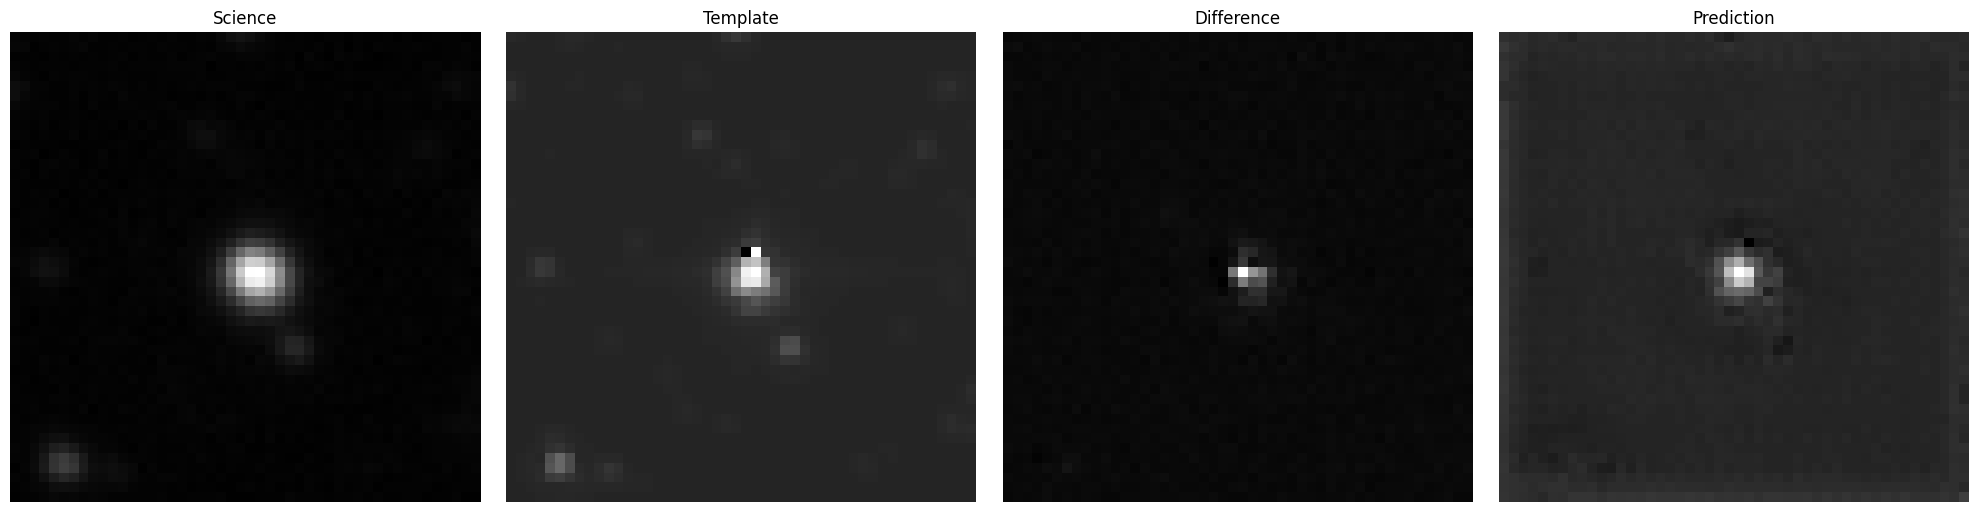

Processing Object ID: ZTF18acguvec, Candid: 2133386680415010125
1/1 [==============================] - 0s 16ms/step


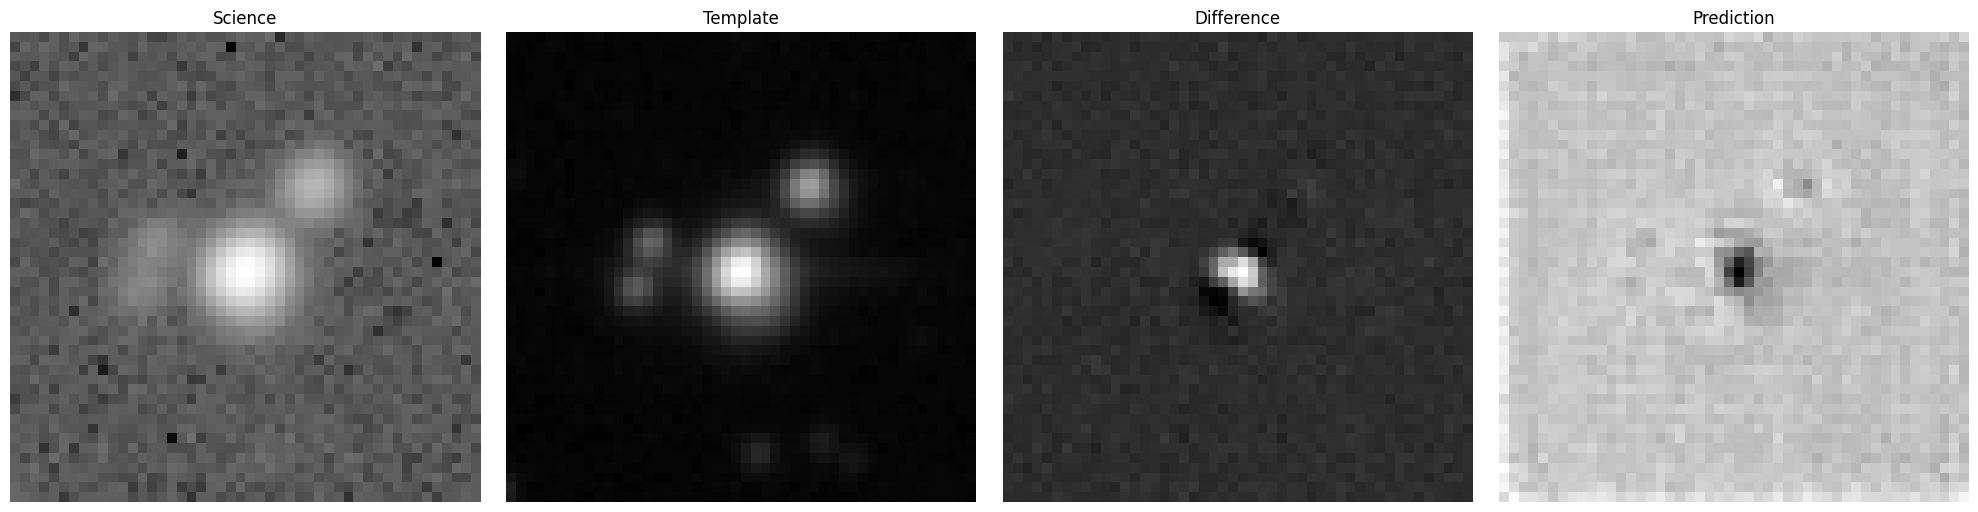

Processing Object ID: ZTF19aazszfj, Candid: 896186504415015008
1/1 [==============================] - 0s 14ms/step


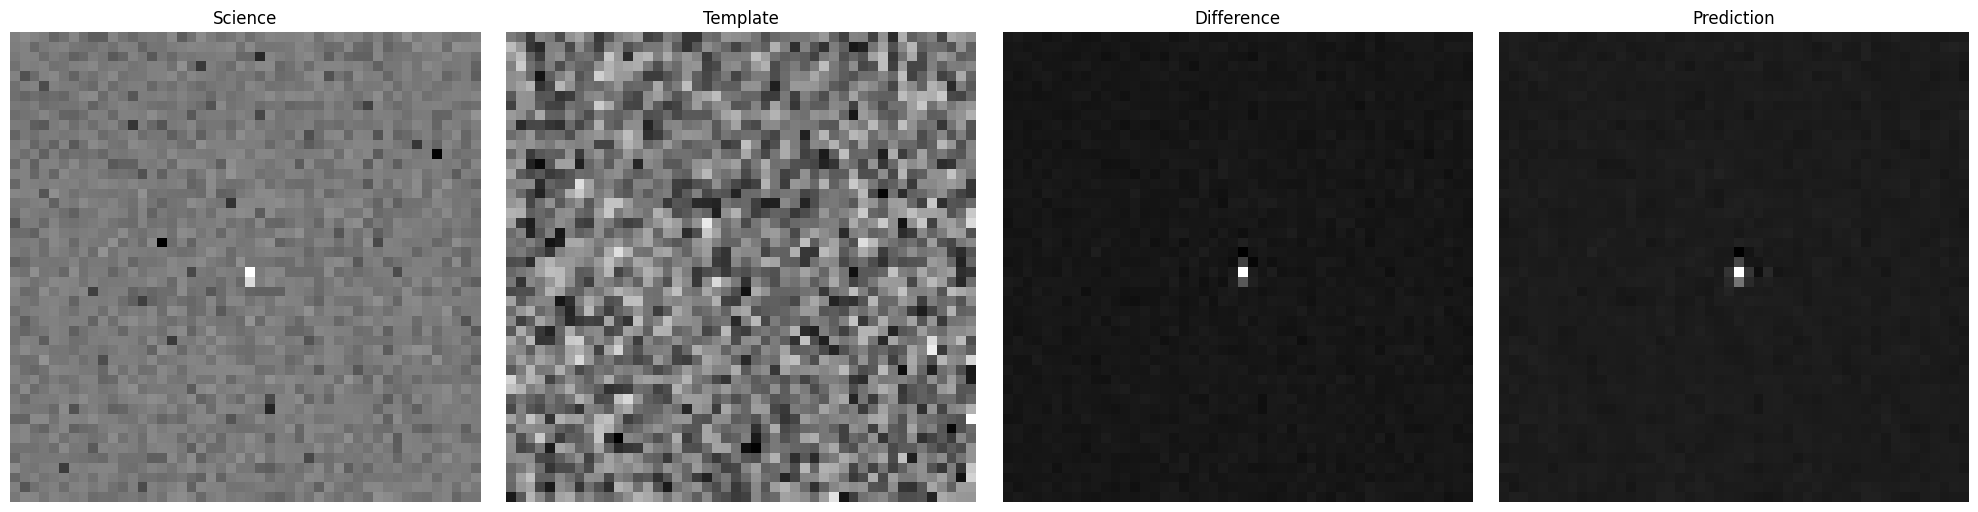

Processing Object ID: ZTF23abownjv, Candid: 2499198502215015007
1/1 [==============================] - 0s 14ms/step


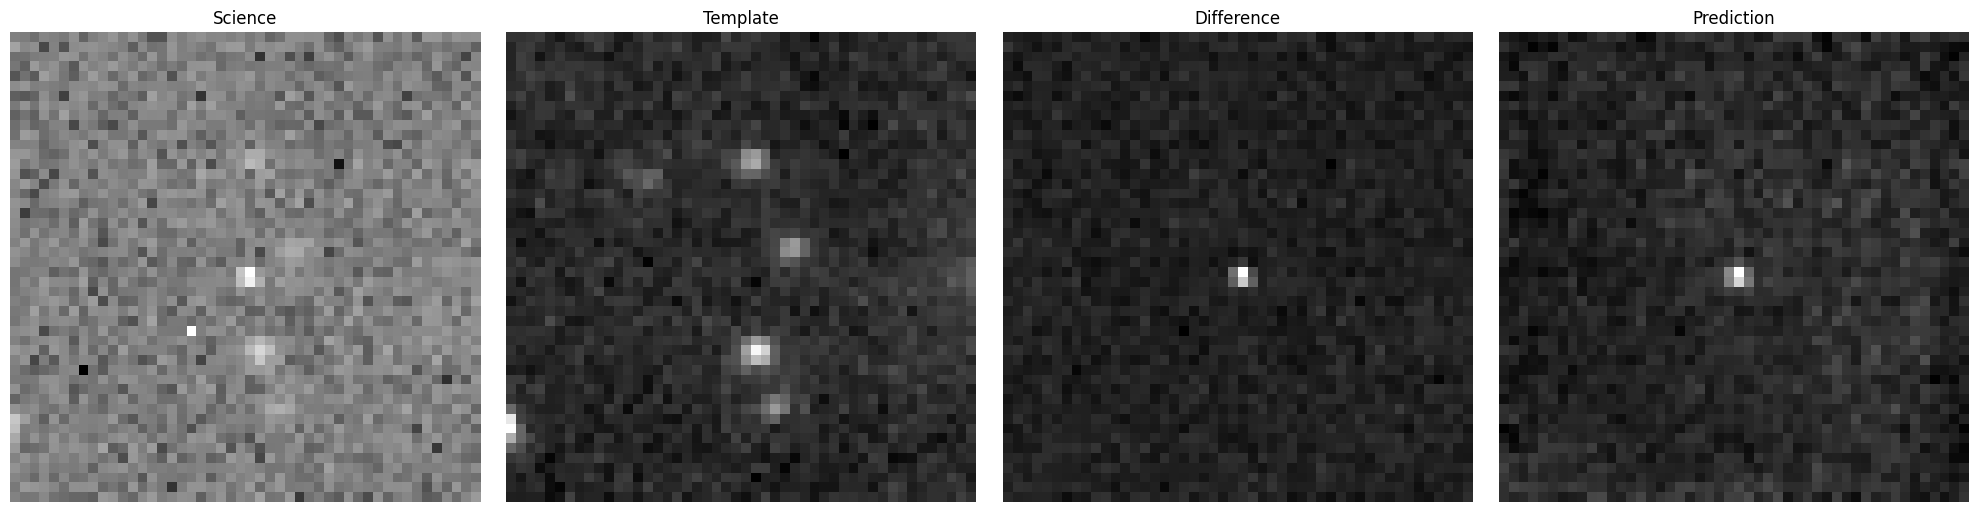

Processing Object ID: ZTF18abgrany, Candid: 1919485001815010050
1/1 [==============================] - 0s 15ms/step


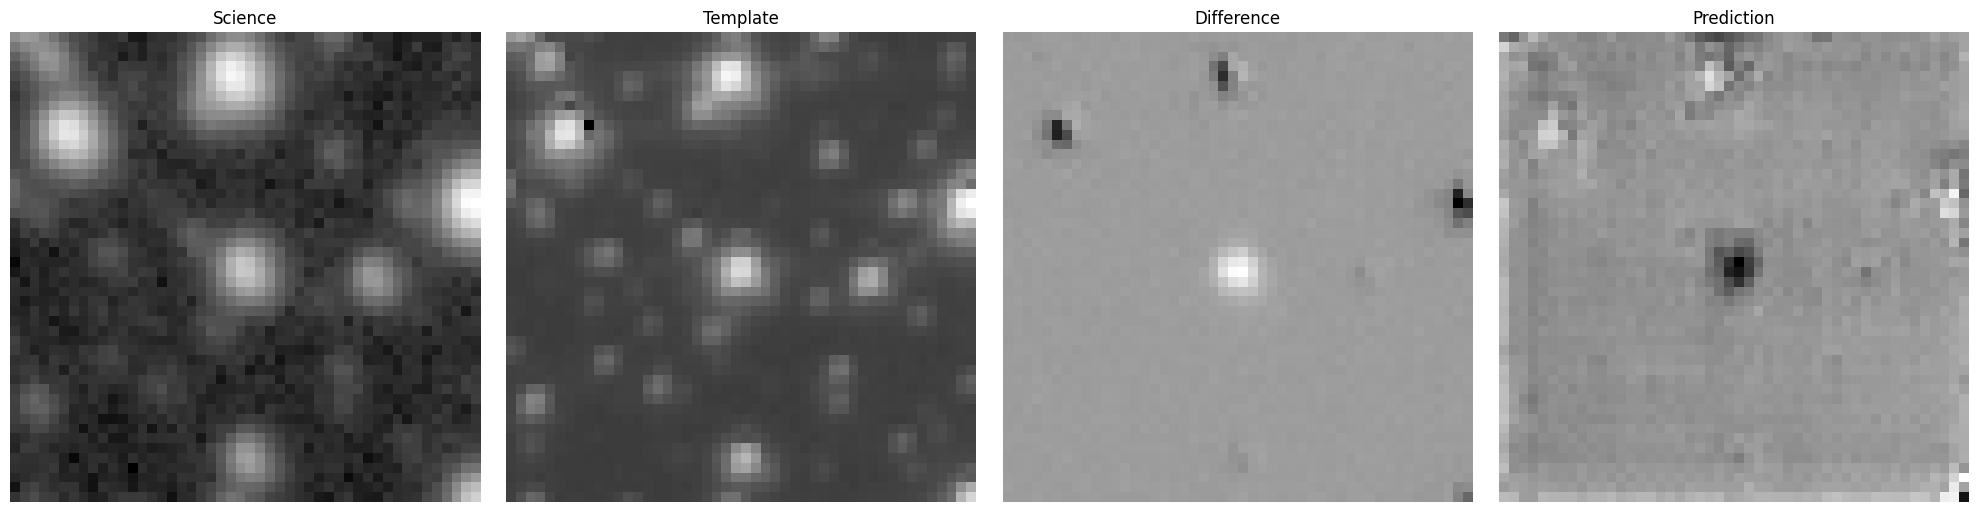

In [5]:
# Function to fetch one triplet
def get_one_triplet(oid, candid):
    try:
        # Get stamps in HDUList format
        candid_stamps = client.get_stamps(oid, candid=candid, format='HDUList')
        return candid_stamps
    except Exception as e:
        logging.error(f"Error processing candid {candid}: {e}")
    return None

# Function to process and predict on fetched triplets and plot results
def process_and_predict(object_id, candid, model):
    triplet = get_one_triplet(object_id, candid)

    if triplet is not None:
        # Process the triplet
        triplet_data = np.stack([hdu.data for hdu in triplet], axis=0)
        
        # Check the size of each image in the triplet
        sizes = [hdu.data.shape for hdu in triplet]
        logging.info(f"Triplet sizes: {sizes}")
        
        input_img, diff_img_rescaled = preprocess_image(triplet_data)
        
        # Extract bottleneck features
        input_img = np.expand_dims(input_img, axis=0)  # Add batch dimension
        
        # Get the model prediction
        prediction = model.predict(input_img)
        
        # Plot the triplet and the prediction
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        titles = ['Science', 'Template', 'Difference', 'Prediction']
        images = [np.log10(input_img[0,:,:,0]), np.log10(input_img[0,:,:,1]), diff_img_rescaled[:,:,0], prediction[0,:,:,0]]
        
        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Failed to fetch a valid triplet.")


# Path to the HDF5 file
hdf5_file = 'Latent_Space/val_bottleneck_features.h5'

# Get the metadata for the closest images
object_ids, candids = retrieve_metadata(hdf5_file, closest_indices)

# Plot the triplet and the prediction
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
titles = ['Science', 'Template', 'Difference', 'Prediction']
images = [input_img[0,:,:,0], input_img[0,:,:,1], diff_img_rescaled[:,:,0], prediction[0,:,:,0]]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()
    
# Process and predict for each of the closest images
for obj_id, candid in zip(object_ids, candids):
    print(f"Processing Object ID: {obj_id}, Candid: {candid}")
    process_and_predict(obj_id, candid, model)